<a href="https://colab.research.google.com/github/PiotrusWatson/level4project/blob/master/data/ipynbs/DeClarE_paperAcc_Politifact_noDPro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeClarE Model on PolitiFact dataset

The DeClarE model is a state of the art fake news detection model that uses Depp learning techniques to classify any input article as being fake or not. This model proposed by Popat et al.(2018) provides a nodel approach to input analysis. As opossed to other fake news detectin models, DeClarE uses external sources to the art as well for classification. It uses the claim text as well as the article and claim source. So in total the model take four inputs including the article itself. The code for DeClarE which is used as the base here can be found at https://github.com/connectsoumya/declare/blob/master/network.py. 

HEY GAMERS ITS TIME TO ANNOTATE THE FUCK OUTTA THIS NOTEBOOK


## All imports

In [0]:
# Needed for weights visualization
!pip install keract

OK THERE ARE WAY MORE IMPORTS HERE THAN IN THE PROVIDED SOURCE. THATS COOL

In [0]:
# The model used in this notebook is a modified version of https://github.com/connectsoumya/declare/blob/master/network.py
# All imports
import json
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import gzip
import spacy
from IPython.display import HTML

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_curve, auc

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Average, Embedding, RepeatVector
from tensorflow.python.keras.layers.pooling import MaxPooling2D , GlobalMaxPooling1D
from tensorflow.python.keras.layers.merge import concatenate

from tensorflow.python.keras.layers import Bidirectional
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers import Dot, Average
from tensorflow.python.keras.backend import mean, expand_dims, gradients, function, tile
from tensorflow.python.keras.layers import Lambda
from tensorflow.python.keras.regularizers import l2,l1
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.optimizers import SGD, Adam
from keract import get_activations
import matplotlib.pyplot as plt
import os
import shutil
import smart_open
from sys import platform
from scipy import spatial
import gensim
from gensim.models.keyedvectors import KeyedVectors

****

OK WHY ARE THEY USING A SEED? THE ORIGINAL DOESN'T

MAYBE ITS FOR TESTING + REPRODUCTION?

In [0]:
# Random seed set to ensure that code provides the same output whenever randomisation is done.
seed = 7
np.random.seed(seed)

THE POLITIFACT DATASET IS USED AS PART OF THE TRAINING SET I THINK?

HOW DOES THIS WORK?

In [0]:
# Get the PolitiFact Dataset from the location provided in the DeClarE paper.
!wget http://resources.mpi-inf.mpg.de/impact/dl_cred_analysis/PolitiFact.zip
!unzip PolitiFact.zip

--2020-04-13 18:57:47--  http://resources.mpi-inf.mpg.de/impact/dl_cred_analysis/PolitiFact.zip
Resolving resources.mpi-inf.mpg.de (resources.mpi-inf.mpg.de)... 139.19.206.46
Connecting to resources.mpi-inf.mpg.de (resources.mpi-inf.mpg.de)|139.19.206.46|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4976217 (4.7M) [application/zip]
Saving to: ‘PolitiFact.zip’

PolitiFact.zip      100%[===================>]   4.75M  3.94MB/s    in 1.2s    

2020-04-13 18:57:49 (3.94 MB/s) - ‘PolitiFact.zip’ saved [4976217/4976217]

Archive:  PolitiFact.zip
   creating: PolitiFact/
  inflating: PolitiFact/README       
  inflating: PolitiFact/politifact.tsv  


BECAUSE SEE: WE ALSO HAVE THE GLOVE DATASET

WHAT'S THAT USED FOR?

In [0]:
# Download the Glove.zip file and expand it.
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2020-04-13 18:57:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-13 18:57:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-13 18:57:51--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

## Politifact Data Load

OK SO WE LOAD THE POLITIFACT DATA INTO PANDAS, WITH SPECIFIED NAMES

THESE NAMES CORRESPOND TO EACH COLUMN

SO LIKE

CRED_LABEL IS THE CREDIBILITY LABEL - OR HOW TRUE THE CLAIM IS SAID TO BE BY POLITIFACT

CLAIM_ID IS A UNIQUE STRING TO IDENTIFY EACH CLAIM

CLAIM_TEXT IS THE TEXT OF THE CLAIM BEING MADE

CLAIM_SOURCE IS WHOEVER MADE THE CLAIM IN THE ARTICLE

AND FINALLY ARTICLE IS THE ARTICLE THE CLAIM CAME FROM

AND ARTICLE_SOURCE IS WHERE THE ARTICLE WAS POSTED TO

In [0]:
# Loading the Politifact csv file
facts=list()
fact=pd.read_csv('./PolitiFact/politifact.tsv', delimiter = '\t', names = ['cred_label','claim_id','claim_text','claim_source','article','article_source'])

In [0]:
# The structure of the politifact.tsv file is following: <cred_label>\t<claim_id>\t<claim_text>\t<claim_source>\t<evidence>\t<evidence_source>
fact.head()

,cred_label,claim_id,claim_text,claim_source,article,article_source
0,True,2012_oct_08_barack-obama_obama-says-tax-code-r...,federal tax code loopholes giving incentives c...,barack obama,for firms moving overseas in order to create a...,foxnews.com
1,True,2012_oct_08_barack-obama_obama-says-tax-code-r...,federal tax code loopholes giving incentives c...,barack obama,get a tax break specifically by outsourcing jo...,newslines.org
2,True,2012_oct_08_barack-obama_obama-says-tax-code-r...,federal tax code loopholes giving incentives c...,barack obama,confusing clashes over taxes in wednesday s pr...,wsj.com
3,True,2012_oct_08_barack-obama_obama-says-tax-code-r...,federal tax code loopholes giving incentives c...,barack obama,support on this bill in a time of tight budget...,senate.gov
4,True,2012_oct_08_barack-obama_obama-says-tax-code-r...,federal tax code loopholes giving incentives c...,barack obama,tax a lower rate for american manufacturing an...,archives.gov


I MADE A HELPER FUNCTION: THIS FUNCTION (GIVEN A COLUMN) SPITS OUT GENERAL STATISTICS AND ALSO SUMMARISES HOW MANY OF EACH CHOICE THERE IS

In [0]:
def view_stats(df):
  label_counts = df.value_counts()
  print(label_counts.describe())
  top_labels = label_counts.nlargest(10)
  top_labels_list = top_labels.index.tolist()
  print(top_labels)
  

In [0]:
# Get the data statistics
view_stats(fact['cred_label'])

count       6.000000
mean     4926.000000
std       900.529178
min      3461.000000
25%      4550.750000
50%      5091.500000
75%      5390.000000
max      6052.000000
Name: cred_label, dtype: float64
False             6052
Half-True         5467
Mostly True       5159
Mostly False      5024
True              4393
Pants on Fire!    3461
Name: cred_label, dtype: int64


## Pre-Process the data

HERE WE SIPHON DOWN THE 6 TRUTH VALUES INTO AN EASIER BINARY ONE

WHERE ALL THE TRUE THINGS ARE 1 AND ALL THE FALSE THINGS ARE 0

I FIND IT INTERESTING THAT THINGS THAT ARE "MOSTLY TRUE" ARE CLASSIFIED AS TRUE

MAYBE THIS ISN'T THE BEST THING FOR A BINARY TRUE/FALSE CLASSIFIER?

In [0]:
# Convert the credibility labels to binary labels where 0 is false and 1 is true.
claim_label = fact['cred_label']
# {'False', 'Half-True', 'Mostly False', 'Mostly True', 'Pants on Fire!', 'True'}
claim_label = [1 if tuple == 'True'  or tuple == 'Half-True' or tuple == 'Mostly True' else 0 for tuple in claim_label]

col = ['claim_label']
lbl = pd.DataFrame(claim_label,columns=col)
view_stats(lbl['claim_label'])

count        2.000000
mean     14778.000000
std        340.825469
min      14537.000000
25%      14657.500000
50%      14778.000000
75%      14898.500000
max      15019.000000
Name: claim_label, dtype: float64
1    15019
0    14537
Name: claim_label, dtype: int64


## Create Training and Test Data for the model

NOW, train_test_split() IS A COOL FUNCTION FOUND IN sklearn.model_selection

IT TAKES IN A LOAD OF ARRAYS AND FOR EACH ONE SPITS OUT TWO MORE WITH RANDOM SELECTIONS OF THE DATA

SETTING THE test_size VARIABLE LETS U GO WILD AND DECIDE HOW MUCH IS IN UR TRAINING SET (LIST 1) COMPARED TO TESTING SET (LIST 2)

In [0]:
def preprocess_fact_data(facts, mapping, slice_function=None, is_folding=False):
  
  facts = facts.replace({"cred_label": mapping})
  unique = facts.drop_duplicates("claim_text")
  if (slice_function):
    unique = slice_function(unique)
  
#splitting the claims
  
  if is_folding:
    results = []
    folded = KFold(n_splits=10, shuffle=True)
    splitted_object = folded.split(unique)
    for train_result, test_result in splitted_object:
      train_ilocs = unique.iloc[train_result]["claim_text"]
      test_ilocs = unique.iloc[test_result]["claim_text"]
      results.append((facts[facts["claim_text"].isin(train_ilocs)], facts[facts["claim_text"].isin(test_ilocs)]))

    return results

  train_unique, big_unique = train_test_split(unique, test_size=0.2, random_state=8)
  val_unique, test_unique = train_test_split(big_unique, test_size=0.5, random_state=8)
  

  

#recreating dataset
  test_facts = facts[facts["claim_text"].isin(test_unique["claim_text"])]
  val_facts = facts[facts["claim_text"].isin(val_unique["claim_text"])]
  train_facts = facts[facts["claim_text"].isin(train_unique["claim_text"])]
  return train_facts, test_facts, val_facts

In [0]:
# Get Train, Test and validation
fact["cred_label"]= claim_label
unique = fact.drop_duplicates("claim_text")
train_unique, big_unique = train_test_split(unique, test_size=0.2, random_state=8)
val_unique, test_unique = train_test_split(big_unique, test_size=0.5, random_state=8)

input_test = fact[fact["claim_text"].isin(test_unique["claim_text"])]
input_val = fact[fact["claim_text"].isin(val_unique["claim_text"])]
input_train = fact[fact["claim_text"].isin(train_unique["claim_text"])]
label_train = input_train["cred_label"]
label_test = input_test["cred_label"]
label_val = input_val["cred_label"]

#input_train_in,input_test,label_train_in,label_test = train_test_split(fact, claim_label, test_size=0.2, random_state=8)

HERE WE TRY AND GET THE NUMBER OF UNIQUE CLAIMS IN THE TEST SET (THAT ALSO AREN'T IN THE TRAINING SET)

SO YOU CHECK WHAT'S NOT IN TRAINING SET

THEN MAKE IT A SET JUST IN CASE

In [0]:
# Code to check how many unique claims are present in the test set.
# Code found here: https://stackoverflow.com/questions/23460345/selecting-unique-rows-between-two-dataframes-in-pandas
unique_test = input_test[~input_test['claim_text'].isin(input_train['claim_text'])]
uniq_set=set(unique_test['claim_text'].tolist())
print("There are %d unique claims in the test set" % (len(uniq_set)))

There are 353 unique claims in the test set


ANOTHER SPLIT, THIS TIME FOR THE ALL IMPORTANT CROSS VALIDATION BAYBEEEEE

In [0]:
#input_train,input_val,label_train,label_val = train_test_split(input_train_in, label_train_in, test_size=0.2, random_state=8)

In [0]:
# Check the statistics of the test data
test_claim_label = input_test['pred_bin']
col = ['pred_bin']
lbl = pd.DataFrame(test_claim_label,columns=col)
view_stats(lbl['pred_bin'])

KeyError: ignored

WE TAKE THE INPUT DATA AND TURN THEM ALL INTO LISTS

In [0]:
print(len(input_test))
# Training data columns as list
clm_list = input_train['claim_text'].tolist()
art_list = input_train['article'].tolist()
clm_src_list = input_train['claim_source'].tolist()
art_src_list = input_train['article_source'].tolist()

# Test data columns as list
test_clm_list = input_test['claim_text'].tolist()
test_art_list = input_test['article'].tolist()
test_clm_src_list = input_test['claim_source'].tolist()
test_art_src_list = input_test['article_source'].tolist()

2855


In [0]:
#Validation data columns as list
val_clm_list = input_val['claim_text'].tolist()
val_art_list = input_val['article'].tolist()
val_clm_src_list = input_val['claim_source'].tolist()
val_art_src_list = input_val['article_source'].tolist()

NEXT UP, WE TAKE THE LISTS, AND TURN THEM INTO SEQUENCES OF NUMBERS

OR: WE TOKENISE THEM

USING A TOKENIZER (FROM KERAS), WE FIRST USE fit_on_texts TO CREATE A UNIQUE NUMBER FOR EACH WORD IN THE CORPUS

THEN, WE USE texts_to_sequences TO MAKE CORRESPONDING LISTS OF NUMBERS OUT OF THE SENTENCES

THESE ARE DIFFERENT SIZES, AND WE WANT TO MAKE A 2D ARRAY OUT OF THIS

SO WE USE pad_sequences TO GIVE US A 2D ARRAY OF SIZE (maxlen) AND ONE WHICH PADS OUT ANY SEQUENCES SMALLER THAN THAT
(AFTER RUNNING OUT, THANKS TO "post")

CURIOUSLY, THIS IS SET TO 100 FOR BOTH, SO WE ONLY STORE THE FIRST 100 WORDS?

In [0]:
# For training data
# Article and claim embedding i.e. word embedding. Here the text to sequence conversions occurs
t = Tokenizer()
t.fit_on_texts(clm_list + art_list)
encoded_claim = t.texts_to_sequences(clm_list)
encoded_art = t.texts_to_sequences(art_list)

max_len = max(encoded_claim, key=len)
max_len_c = 100
padded_claim = pad_sequences(encoded_claim, maxlen=max_len_c, padding='post')

max_len = max(encoded_art, key=len)
max_len_a = 100
padded_art = pad_sequences(encoded_art, maxlen=max_len_a, padding='post')

OH BOY



SO WE SEEM TO HAVE A THING THAT STORES BOTH THE WORD AND ITS CORRESPONDING VECTOR

THIS IS THE GLOVE DATASET - WE DON'T CREATE THE WORD EMBEDDINGS, JUST INSTEAD KINDA STEAL THEM?

FOR EACH WORD IN THE FILE JEEZ WE SEE IF ITS IN OUR WORD INDEX

THEN WE FILL OUT OUR PREMADE EMBEDDING MATRIX WITH THE WORD 

INTERESTINGLY, THIS CUTS OFF THE VECTOR GIVEN - IS THAT RELEVANT? DOES THAT RUIN DATA?

BUT AS WE'VE FILLED THE ENTIRE MATRIX OUT WITH 0, WE KNOW EXACTLY WHERE WE CAN'T FIND WORDS



In [0]:
def create_embed_matrix(vocab_size, embedding_dim,word_index):
  embedding_matrix = np.zeros((vocab_size, embedding_dim))
  with open('glove.6B.100d.txt') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
  return embedding_matrix


# Get the embedding matrix of the vocabulary from Glove 100.
vocab_size = len(t.word_index) + 1 #size of vocab in article sets
embedding_dim = 100
word_index = t.word_index

embedding_matrix = create_embed_matrix(vocab_size, embedding_dim, word_index)

YO SO WE'RE NOT MISSING TOO MANY WORDS

In [0]:
# To find how many words of the input text the embedding contains 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9999703844103536

OK EARLIER WE CONVERTED THE CLAIMS + ARTICLES TO SEQUENCES

BUT NOW WE NEED TO DO IT FOR THE SOURCES AS WELL?

SO MUCH REUSED CODE HERE:

I'M NOT SURE HOW WELL THIS WORKS



In [0]:
# Claim source embedding
t_csrc = Tokenizer()
t_csrc.fit_on_texts(clm_src_list)
encoded_claim_src = t_csrc.texts_to_sequences(clm_src_list)

max_len = max(encoded_claim_src, key=len)
max_len_cs = 4
padded_claim_src = pad_sequences(encoded_claim_src, maxlen=max_len_cs, padding='post')
# Create embedding matrix for claim source
vocab_size_csrc = len(t_csrc.word_index) + 1
embedding_matrix_csrc = create_embed_matrix(vocab_size_csrc, 4, t_csrc.word_index)
    
# For article source embedding    
t_asrc = Tokenizer()
t_asrc.fit_on_texts(art_src_list)
encoded_art_src = t_asrc.texts_to_sequences(art_src_list)

max_len = max(encoded_art_src, key=len)
max_len_as = 4
padded_art_src = pad_sequences(encoded_art_src, maxlen=max_len_as, padding='post')
# Create embedding matrix for article source
vocab_size_asrc = len(t_asrc.word_index) + 1
embedding_matrix_asrc = create_embed_matrix(vocab_size_asrc, 4, t_asrc.word_index)

WE ALSO DO IT FOR THE VALIDATION DATA

BUT NOTABLY DO NOT CREATE EMBED MATRICES FOR IT

WHY? I DUNNO LOL

SO INSTEAD THE VALIDATION DATA + TEST DATA JUST HAVE NUMBER SEQUENCES

NOT WORD EMBEDDING MATRICES



In [0]:
# Validation data
# Claim and article

encoded_claim_val = t.texts_to_sequences(val_clm_list)
encoded_art_val = t.texts_to_sequences(val_art_list)

max_len_val = max(encoded_claim_val, key=len)
max_len_c_val = 100
padded_claim_val = pad_sequences(encoded_claim_val, maxlen=max_len_c_val, padding='post')

max_len_val = max(encoded_art_val, key=len)
max_len_a_val = 100
padded_art_val = pad_sequences(encoded_art_val, maxlen=max_len_a_val, padding='post')


# Claim Sources data
encoded_claim_src_val = t_csrc.texts_to_sequences(val_clm_src_list)

max_len_val = max(encoded_claim_src_val, key=len)
max_len_cs_val = 4
padded_claim_src_val = pad_sequences(encoded_claim_src_val, maxlen=max_len_cs_val, padding='post')

# Article Sources data
encoded_art_src_val = t_asrc.texts_to_sequences(val_art_src_list)

max_len_val = max(encoded_art_src_val, key=len)
max_len_as_val = 4
padded_art_src_val = pad_sequences(encoded_art_src_val, maxlen=max_len_as_val, padding='post')

ALSO THE SAME FOR THE TEST DATA!

WHY?

In [0]:
# Test Data
# Claim and article

encoded_claim_test = t.texts_to_sequences(test_clm_list)
encoded_art_test = t.texts_to_sequences(test_art_list)

max_len_test = max(encoded_claim_test, key=len)
max_len_c_test = 100
padded_claim_test = pad_sequences(encoded_claim_test, maxlen=max_len_c_test, padding='post')

max_len_test = max(encoded_art_test, key=len)
max_len_a_test = 100
padded_art_test = pad_sequences(encoded_art_test, maxlen=max_len_a_test, padding='post')


# Claim Sources data
encoded_claim_src_test = t_csrc.texts_to_sequences(test_clm_src_list)

max_len_test = max(encoded_claim_src_test, key=len)
max_len_cs_test =4
padded_claim_src_test = pad_sequences(encoded_claim_src_test, maxlen=max_len_cs_test, padding='post')

# Article sources data
encoded_art_src_test = t_asrc.texts_to_sequences(test_art_src_list)

max_len_test = max(encoded_art_src_test, key=len)
max_len_as_test = 4
padded_art_src_test = pad_sequences(encoded_art_src_test, maxlen=max_len_as_test, padding='post')

STOLEN CODE THAT ALLOWS US TO PLOT THE HISTORY GIVEN BY A HISTORY OBJECT SO WE CAN SEE HOW GOOD WE'RE LEARNING

ALSO ACCURACY ETC

In [0]:
# Method to plot the accuracy and los graph from the history object. Code found in https://realpython.com/python-keras-text-classification/
plt.style.use('ggplot')
from google.colab import files
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    savefig("hi.svg", format="svg")
    files.download('hi.svg')

In [0]:
def get_results(model_name, dataset_name, predictions, true_labels):
  precision = precision_score(predictions, true_labels, average='macro')
  recall = recall_score(predictions, true_labels, average='macro')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1, average='macro')
  f1_micro = fbeta_score(predictions, true_labels,1, average="micro") #1 means f_1 measure
  fpr, tpr, thresholds = roc_curve(true_labels, predictions)
  auc_full = auc(fpr, tpr)

  return {"model_name":model_name,
                  "dataset_name": dataset_name,
                  "precision":precision,
                  "recall": recall,
                  "accuracy": accuracy,
                  "f1": f1,
                  "f1_micro": f1_micro,
                  "auc": auc_full}

def list_to_dict(results):
  big_results = {"model_name": [],
                 "dataset_name": [],
                "precision": [],
                 "recall": [],
                 "accuracy": [],
                 "f1": [],
                 "f1_micro": [],
                 "auc": []}
  for result in results:
    for key in result:
      big_results[key].append(result[key])

  return pd.DataFrame.from_dict(big_results)

def process_results(big_results):
  return (big_results["model_name"][0], big_results["dataset_name"][0], big_results.mean(), big_results.std())

## Bi-LSTM- Simple DeClarE (lr=0.002) & (lr=0.0001)

IT BEGINS

THIS IS A SIMPLE DECLARE, ONLY USING A BIDIRECTIONAL LSTM





In [0]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
# This DeCalrE model only uses Bi-LSTM called Simple DeClarE
lstm_op_dim = 64 #the number of dimensions
art_wrd1 = Input(shape=(max_len_a,)) #an input layer, provided by keras. It has its x axis constrained to the size of this walnut only way smaller
art_wrd_emb1 = Embedding(vocab_size, 100, input_length=max_len_a, weights=[embedding_matrix], trainable=False)(art_wrd1) # article embedding
#this is an embedding layer, which exists probably from keras models. we're telling it how big the vocab is, passing it in the existing embedding matrix we generated, and
#but then we've already provided pre-existing embedding matrices, so we don't need to train it further
# Bi-LSTM
#this is a bidirectional lstm, and we first wanna give it a decent number of dimensions
lstm_op2 = Bidirectional(LSTM(lstm_op_dim, return_sequences=True, recurrent_regularizer=l2(0.00001), kernel_regularizer=l2(0.01)),
                         merge_mode='concat')(art_wrd_emb1)

# Fatten layer
flat = Flatten()(lstm_op2)
# Claim source embedding
clm_src1 = Input(shape=(max_len_cs,))
clm_src_emb1 = Embedding(vocab_size_csrc, 4, input_length=max_len_cs, weights=[embedding_matrix_csrc], trainable=False)(clm_src1) # claim source embedding
# Flatten layer
clm_src_emb_flatten1 = Flatten()(clm_src_emb1)
# Article source embedding
art_src1 = Input(shape = (max_len_as,))
art_src_emb1 = Embedding(vocab_size_asrc, 4, input_length=max_len_as, weights=[embedding_matrix_asrc], trainable=False)(art_src1)
art_src_emb_flatten1 = Flatten()(art_src_emb1)

# End dense layers
dense1 = Dense(8, activation='relu',kernel_regularizer=l2(0.01))(flat)
dense1 = Dense(1, activation='sigmoid',kernel_regularizer=l2(0.01))(dense1)

model_lstm2 = Model(inputs=art_wrd1, outputs=dense1)
adam = Adam(lr=0.0001)
#adam = Adam(lr=0.002) # Also used in second run
model_lstm2.compile(optimizer=adam,
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
print(model_lstm2.summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 100, 100)          3376600   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 128)          84480     
_________________________________________________________________
flatten_10 (Flatten)         (None, 12800)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 102408    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 3,563,497
Trainable params: 186,897
Non-trainable params: 3,376,600
___________________________________________

In [0]:
# Train model when learning rate = 0.0001
history_001 = model_lstm2.fit(padded_art, label_train,
                    epochs=30,
                    validation_data=(padded_art_val, label_val),
                    batch_size=100)

Train on 23817 samples, validate on 2884 samples
Epoch 1/30
 2500/23817 [==>...........................] - ETA: 31s - loss: 3.6830 - accuracy: 0.4868

KeyboardInterrupt: ignored

In [0]:
# Train model when learning rate = 0.002
history_02 = model_lstm2.fit(padded_art, label_train,
                    epochs=30,
                    validation_data=(padded_art_val, label_val),
                    batch_size=100)

In [0]:
# Plot the accuracy and loss graphs for when lr = 0.0001 and 0.002
loss, accuracy = model_lstm2.evaluate(padded_art_val, label_val, verbose=False)
print("Validation Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_lstm2.evaluate(padded_art_test,label_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_001)
plot_history(history_02)

In [0]:
# Predict the test data
y_pred = model_lstm2.predict(padded_art_test)

### Misc functions

In [0]:
# Convert the predicted values to 0 or 1
def get_proper_labels(y_pred):
  prop_label = [1 if tuple>=0.5 else 0 for tuple in y_pred]
  return prop_label

In [0]:
# Method to plot the confusion matrix. Code taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=['False','True'], yticklabels=['False','True'],
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.grid(False)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
# Code taken from Lab5 of TaD by Jeff Dalton. This method returns the accuarcy, precision, recall and F1 measure values for an input.
def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision = precision_score(predictions, true_labels, average='macro')
  recall = recall_score(predictions, true_labels, average='macro')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1, average='macro') #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.4f P=%0.4f R=%0.4f F1=%0.4f" % (description,accuracy,precision,recall,f1))
  print(classification_report(predictions, true_labels, digits=3))
  print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions))
  return precision,recall,accuracy,f1

### Model Evaluation

In [0]:
# Convert to 0 or 1
y_pred_bin = get_proper_labels(y_pred)

NameError: ignored

In [0]:
# When lr=0.0001
plot_confusion_matrix(label_test,y_pred_bin,[0,1])
plot_confusion_matrix(label_test,y_pred_bin,[0,1], normalize=True)

NameError: ignored

Confusion matrix, without normalization
[[1688 1230]
 [ 673 2321]]
Normalized confusion matrix
[[0.57847841 0.42152159]
 [0.2247829  0.7752171 ]]


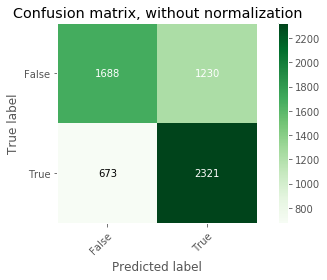

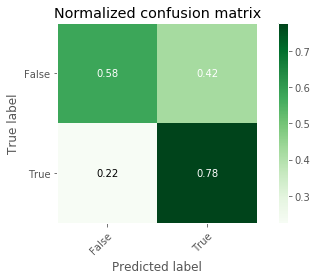

In [0]:
#When lr=0.002
plot_confusion_matrix(label_test,y_pred_bin,[0,1])
plot_confusion_matrix(label_test,y_pred_bin,[0,1], normalize=True)

In [0]:
# This is the outcome of lr=0.0001
basic_p,basc_r,basic_a,basic_f1 = evaluation_summary("DeClare-Basic", y_pred_bin, label_test)

Evaluation for: DeClare-Basic
Classifier 'DeClare-Basic' has Acc=0.6830 P=0.6831 R=0.6831 F1=0.6830
              precision    recall  f1-score   support

           0      0.689     0.675     0.682      2976
           1      0.677     0.691     0.684      2936

    accuracy                          0.683      5912
   macro avg      0.683     0.683     0.683      5912
weighted avg      0.683     0.683     0.683      5912


Confusion matrix:
 [[2010  908]
 [ 966 2028]]


In [0]:
# Calculate the AUC value of the result when lr=0.0001
fpr, tpr, thresholds = roc_curve(label_test, y_pred_bin)
auc_basic = auc(fpr, tpr)
print("DeClarE Basic AUC-",auc_basic)

DeClarE Basic AUC- 0.6830913368889939


In [0]:
# This is the outcome of lr=0.002
basic_p,basc_r,basic_a,basic_f1 = evaluation_summary("DeClare-Basic", y_pred_bin, label_test)

Evaluation for: DeClare-Basic
Classifier 'DeClare-Basic' has Acc=0.6781 P=0.6768 R=0.6843 F1=0.6744
              precision    recall  f1-score   support

           0      0.578     0.715     0.640      2361
           1      0.775     0.654     0.709      3551

    accuracy                          0.678      5912
   macro avg      0.677     0.684     0.674      5912
weighted avg      0.697     0.678     0.681      5912


Confusion matrix:
 [[1688 1230]
 [ 673 2321]]


In [0]:
# Calculate the AUC value of the result when lr = 0.002
fpr, tpr, thresholds = roc_curve(label_test, y_pred_bin)
auc_basic = auc(fpr, tpr)
print("DeClarE Basic AUC-",auc_basic)

DeClarE Basic AUC- 0.6768477553690886


## DeClarE Simple + Attn (lr=0.002) & (lr=0.0001)

In [0]:
# DeClarE model- Simple + Attention
lstm_op_dim = 64

clm_wrd = Input(shape=(max_len_c,))
clm_wrd_emb = Embedding(vocab_size, 100, input_length=max_len_c, weights=[embedding_matrix], trainable=False)(clm_wrd) # claim embedding
mean_clm_wrd_emb = Lambda(lambda xin: mean(xin, axis=1))(clm_wrd_emb) # average of the embedding
mean_clm_wrd_emb_exp = RepeatVector(100)(mean_clm_wrd_emb) # Repeat vector to increase the matrix size for flatten
mean_clm_wrd_emb_flat = Flatten()(mean_clm_wrd_emb_exp) # Flatten layer

art_wrd1 = Input(shape=(max_len_a,))
art_wrd_emb1 = Embedding(vocab_size, 100, input_length=max_len_a, weights=[embedding_matrix], trainable=False)(art_wrd1) # article embedding
art_wrd_emb_flat = Flatten()(art_wrd_emb1) # Flatten layer

ip_to_dense = concatenate(axis=-1, inputs = [mean_clm_wrd_emb_flat, art_wrd_emb_flat]) # concatenation of article and claim embedding
# Attention mechanism
attn_weights = Dense(128, activation='tanh')(ip_to_dense)
attn_weights = Activation('softmax')(attn_weights)

model_attn_wts = Model(inputs=[clm_wrd, art_wrd1], outputs=attn_weights)
# Bi-LSTM on article embedding
lstm_op2 = Bidirectional(LSTM(lstm_op_dim, return_sequences=True, recurrent_regularizer=l2(0.00001), kernel_regularizer=l2(0.01)),
                         merge_mode='concat')(art_wrd_emb1)
model_lstm = Model(inputs=art_wrd1, outputs=lstm_op2)

# Dot product of output of attention mechanism and Bi-LSTM
inner_pdt = Dot(axes=-1)([model_attn_wts.output, model_lstm.output])
inner_pdt = RepeatVector(3)(inner_pdt)
mean_dim = Lambda(lambda xin: mean(xin, axis=-1))(inner_pdt) # Average of the output

# End dense layers
dense1 = Dense(8, activation='relu',kernel_regularizer=l2(0.01))(mean_dim)
drop1 = Dropout(rate = 0.2)(dense1)
dense1 = Dense(8, activation='relu',kernel_regularizer=l2(0.01))(drop1)
dense1 = Dense(1, activation='sigmoid',kernel_regularizer=l2(0.01))(dense1)

model_dec1 = Model(inputs=[clm_wrd,art_wrd1], outputs=dense1)
#adam = Adam(lr=0.002) # Also used at second turn
adam = Adam(lr=0.0001)
model_dec1.compile(optimizer=adam,
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
print(model_dec1.summary())

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 100, 100)     3376600     input_12[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 100)          0           embedding_11[0][0]               
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 100)]        0                                            
____________________________________________________________________________________________

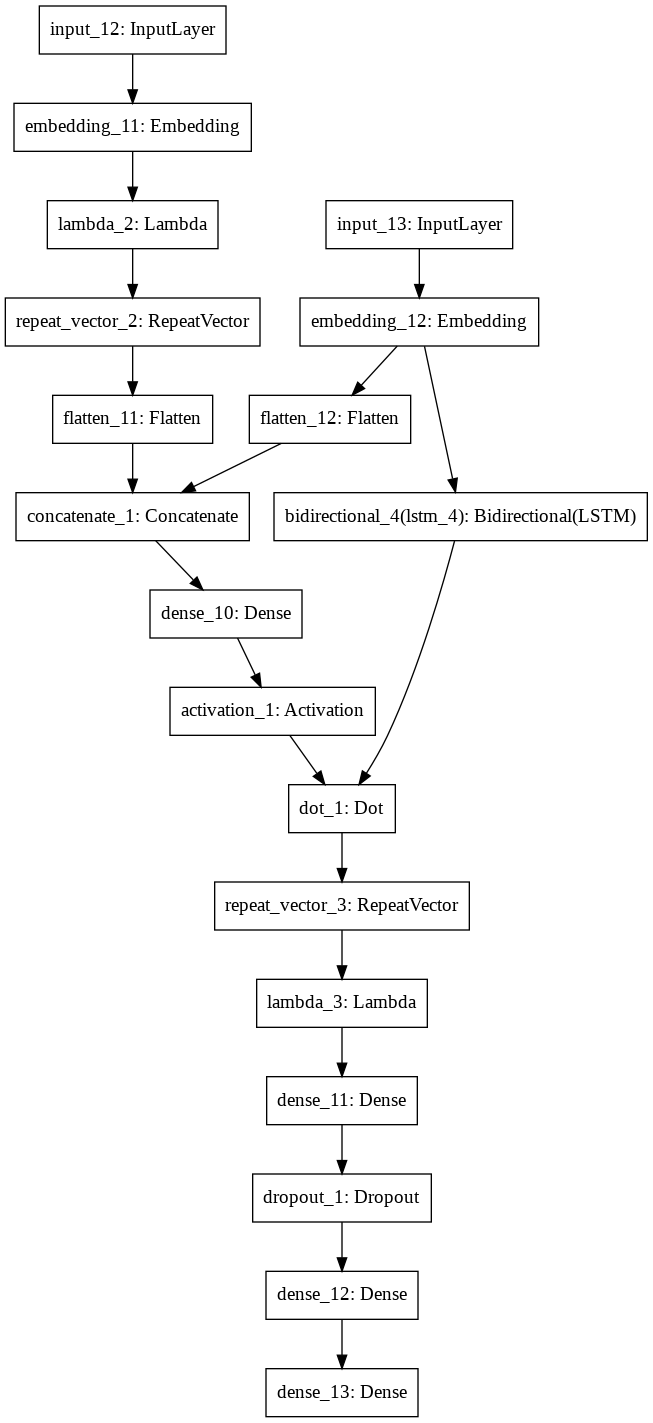

In [0]:
# Get the image of the model structure
plot_model(model_dec1, to_file='declare_art_cl.png')

In [0]:
# Model training when lr=0.0001
results = []
for i in range(10):
  history3 = model_dec1.fit([padded_claim,padded_art], label_train,
                    epochs=30,
                    validation_data=([padded_claim_val,padded_art_val], label_val),
                    batch_size=100)
  y_pred3 = model_dec1.predict([padded_claim_test,padded_art_test])
  y_pred_bin3 = get_proper_labels(y_pred3)
  result = get_results("deClaRe", "politifact", y_pred_bin3, label_test)
  print(result)
  results.append(result)

Train on 23817 samples, validate on 2884 samples
Epoch 1/30
23817/23817 [==============================] - 38s 2ms/sample - loss: 3.0306 - accuracy: 0.5185 - val_loss: 2.4498 - val_accuracy: 0.6127
Epoch 2/30
23817/23817 [==============================] - 37s 2ms/sample - loss: 2.0434 - accuracy: 0.5859 - val_loss: 1.6981 - val_accuracy: 0.5846
Epoch 3/30
23817/23817 [==============================] - 38s 2ms/sample - loss: 1.4556 - accuracy: 0.6282 - val_loss: 1.2579 - val_accuracy: 0.6234
Epoch 4/30
23817/23817 [==============================] - 38s 2ms/sample - loss: 1.1119 - accuracy: 0.6811 - val_loss: 1.0078 - val_accuracy: 0.6092
Epoch 5/30
23817/23817 [==============================] - 37s 2ms/sample - loss: 0.9149 - accuracy: 0.7178 - val_loss: 0.8712 - val_accuracy: 0.6335
Epoch 6/30
23817/23817 [==============================] - 37s 2ms/sample - loss: 0.8004 - accuracy: 0.7463 - val_loss: 0.7992 - val_accuracy: 0.6210
Epoch 7/30
23817/23817 [==============================] -

In [0]:
process_results(list_to_dict(results))

In [0]:
# Model training when lr=0.002
history3_02 = model_dec1.fit([padded_claim,padded_art], label_train,
                    epochs=30,
                    validation_data=([padded_claim_val,padded_art_val], label_val),
                    batch_size=100)

In [0]:
# Get the accuracy and loss graphs for both learning rates
loss, accuracy = model_dec1.evaluate([padded_claim_val,padded_art_val], label_val, verbose=False)
print("Validation Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_dec1.evaluate([padded_claim_test,padded_art_test],label_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history3)
print('LR=0.0001,LR=0.002')
plot_history(history3_02)

In [0]:
# predict the test data
y_pred3 = model_dec1.predict([padded_claim_test,padded_art_test])
y_pred_bin3 = get_proper_labels(y_pred3)

Confusion matrix, without normalization
[[1884 1034]
 [ 947 2047]]
Normalized confusion matrix
[[0.6456477  0.3543523 ]
 [0.31629927 0.68370073]]


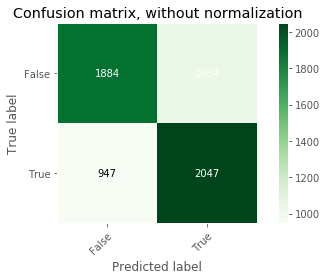

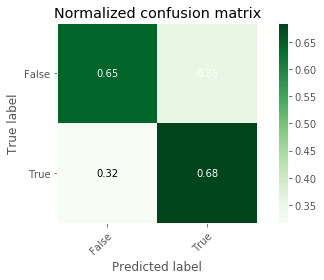

In [0]:
#When lr=0.0001
plot_confusion_matrix(label_test,y_pred_bin3,[0,1])
plot_confusion_matrix(label_test,y_pred_bin3,[0,1], normalize=True)

In [0]:
#When lr=0.0001
basic_att_p,basc_att_r,basic_att_a,basic_att_f1 = evaluation_summary("DeClare-Attn+BiLSTM", y_pred_bin3, label_test)

Evaluation for: DeClare-Attn+BiLSTM
Classifier 'DeClare-Attn+BiLSTM' has Acc=0.6649 P=0.6647 R=0.6649 F1=0.6647
              precision    recall  f1-score   support

           0      0.646     0.665     0.655      2831
           1      0.684     0.664     0.674      3081

    accuracy                          0.665      5912
   macro avg      0.665     0.665     0.665      5912
weighted avg      0.665     0.665     0.665      5912


Confusion matrix:
 [[1884 1034]
 [ 947 2047]]


In [0]:
#When lr=0.0001
fpr, tpr, thresholds = roc_curve(label_test, y_pred_bin3)
auc_basic_att = auc(fpr, tpr)
print("DeClarE Basic_Attn AUC-",auc_basic_att)

DeClarE Basic_Attn AUC- 0.6646742193548624


In [0]:
# When lr=0.002
basic_att_p,basc_att_r,basic_att_a,basic_att_f1 = evaluation_summary("DeClare-Basic_Attn", y_pred_bin3, label_test)

Evaluation for: DeClare-Basic_Attn
Classifier 'DeClare-Basic_Attn' has Acc=0.5064 P=0.5000 R=0.2532 F1=0.3362
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      1.000     0.506     0.672      5912

    accuracy                          0.506      5912
   macro avg      0.500     0.253     0.336      5912
weighted avg      1.000     0.506     0.672      5912


Confusion matrix:
 [[   0 2918]
 [   0 2994]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
# when lr=0.002
fpr, tpr, thresholds = roc_curve(label_test, y_pred_bin3)
auc_basic_att = auc(fpr, tpr)
print("DeClarE Basic_Attn AUC-",auc_basic_att)

DeClarE Basic_Attn AUC- 0.5


## Bi-LSTM- Simple + SourceEmb DeClarE (lr=0.002) & (lr = 0.0001)

In [0]:
# DeClarE Model- Simple + Source Embeddings
lstm_op_dim = 64
art_wrd1 = Input(shape=(max_len_a,))
art_wrd_emb1 = Embedding(vocab_size, 100, input_length=max_len_a, weights=[embedding_matrix], trainable=False)(art_wrd1) # article embedding
lstm_op2 = Bidirectional(LSTM(lstm_op_dim, return_sequences=True, recurrent_regularizer=l2(0.00001), kernel_regularizer=l2(0.01)),
                         merge_mode='concat')(art_wrd_emb1) # Bi-LSTM layer
# Fatten layer
flat = Flatten()(lstm_op2)
# Claim embedding
clm_src1 = Input(shape=(max_len_cs,))
clm_src_emb1 = Embedding(vocab_size_csrc, 4, input_length=max_len_cs, weights=[embedding_matrix_csrc], trainable=False)(clm_src1)
clm_src_emb_flatten1 = Flatten()(clm_src_emb1)
# Article embedding
art_src1 = Input(shape = (max_len_as,))
art_src_emb1 = Embedding(vocab_size_asrc, 4, input_length=max_len_as, weights=[embedding_matrix_asrc], trainable=False)(art_src1)
art_src_emb_flatten1 = Flatten()(art_src_emb1)

#Concatenate the article with the source embeddings
con = concatenate(inputs = [clm_src_emb_flatten1, flat, art_src_emb_flatten1])

# End dense layers
dense1 = Dense(8, activation='relu',kernel_regularizer=l2(0.01))(con)
dense1 = Dense(1, activation='sigmoid',kernel_regularizer=l2(0.01))(dense1)

model_lstm3 = Model(inputs=[clm_src1,art_wrd1,art_src1], outputs=dense1)
#adam = Adam(lr=0.002) # Also used in the second round
adam = Adam(lr=0.0001)
model_lstm3.compile(optimizer=adam,
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
print(model_lstm3.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 100)     3376600     input_4[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 4)]          0                                            
____________________________________________________________________________________________

In [0]:
# Model training when lr=0.0001
history2_01 = model_lstm3.fit([padded_claim_src,padded_art,padded_art_src], label_train,
                    epochs=30,
                    validation_data=([padded_claim_src_val,padded_art_val,padded_art_src_val], label_val),
                    batch_size=100)

Train on 23817 samples, validate on 2884 samples
Epoch 1/30
 5100/23817 [=====>........................] - ETA: 22s - loss: 3.5725 - accuracy: 0.5563

KeyboardInterrupt: ignored

In [0]:
#Model training when lr=0.002
history2 = model_lstm3.fit([padded_claim_src,padded_art,padded_art_src], label_train,
                    epochs=30,
                    validation_data=([padded_claim_src_val,padded_art_val,padded_art_src_val], label_val),
                    batch_size=100)

Train on 18915 samples, validate on 4729 samples
Epoch 1/30
18915/18915 [==============================] - 60s 3ms/step - loss: 1.1330 - acc: 0.5098 - val_loss: 0.7272 - val_acc: 0.5035
Epoch 2/30
18915/18915 [==============================] - 56s 3ms/step - loss: 0.7098 - acc: 0.5099 - val_loss: 0.7028 - val_acc: 0.5035
Epoch 3/30
18915/18915 [==============================] - 56s 3ms/step - loss: 0.7030 - acc: 0.5095 - val_loss: 0.6997 - val_acc: 0.5035
Epoch 4/30
18915/18915 [==============================] - 56s 3ms/step - loss: 0.6986 - acc: 0.5099 - val_loss: 0.6979 - val_acc: 0.5035
Epoch 5/30
18915/18915 [==============================] - 56s 3ms/step - loss: 0.6991 - acc: 0.5099 - val_loss: 0.6972 - val_acc: 0.5035
Epoch 6/30
18915/18915 [==============================] - 56s 3ms/step - loss: 0.6976 - acc: 0.5059 - val_loss: 0.6955 - val_acc: 0.5035
Epoch 7/30
18915/18915 [==============================] - 56s 3ms/step - loss: 0.6950 - acc: 0.5089 - val_loss: 0.6947 - val_acc:

Validation Accuracy: 0.7139
5912/5912 [==============================] - 7s 1ms/step
Testing Accuracy:  0.6964


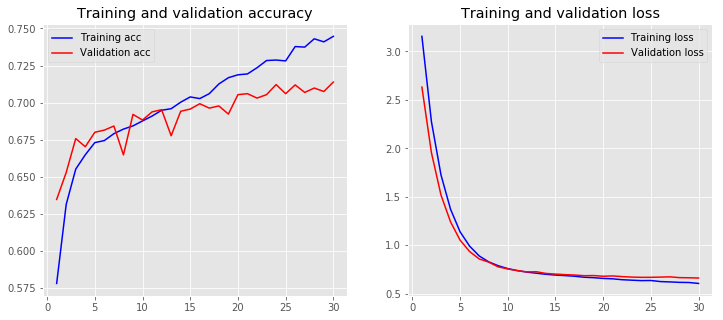

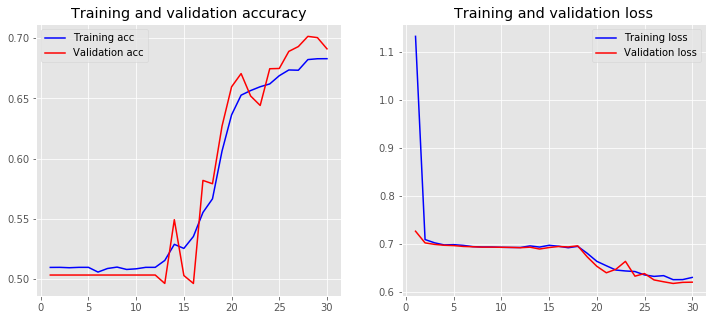

In [0]:
# Get the accuracy and loss graphs for both learning rates
loss, accuracy = model_lstm3.evaluate([padded_claim_src_val,padded_art_val,padded_art_src_val], label_val, verbose=False)
print("Validation Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_lstm3.evaluate([padded_claim_src_test,padded_art_test,padded_art_src_test],label_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history2_01)
plot_history(history2)

In [0]:
# Predict the test data and get the values as 0 or 1
y_pred2 = model_lstm3.predict([padded_claim_src_test,padded_art_test,padded_art_src_test])
y_pred_bin2 = get_proper_labels(y_pred2)

Confusion matrix, without normalization
[[2090  828]
 [ 967 2027]]
Normalized confusion matrix
[[0.716244   0.283756  ]
 [0.32297929 0.67702071]]


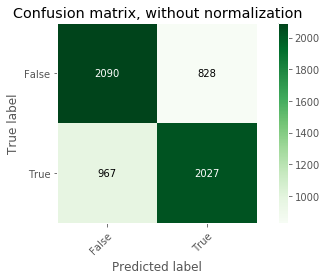

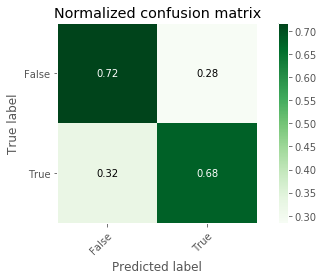

In [0]:
# When lr=0.0001
plot_confusion_matrix(label_test,y_pred_bin2,[0,1])
plot_confusion_matrix(label_test,y_pred_bin2,[0,1], normalize=True)

In [0]:
# When lr=0.0001
basic_src_p,basc_src_r,basic_src_a,basic_src_f1 = evaluation_summary("DeClare-Basic_srcEmb", y_pred_bin2, label_test)

Evaluation for: DeClare-Basic_srcEmb
Classifier 'DeClare-Basic_srcEmb' has Acc=0.6964 P=0.6966 R=0.6968 F1=0.6963
              precision    recall  f1-score   support

           0      0.716     0.684     0.700      3057
           1      0.677     0.710     0.693      2855

    accuracy                          0.696      5912
   macro avg      0.697     0.697     0.696      5912
weighted avg      0.697     0.696     0.696      5912


Confusion matrix:
 [[2090  828]
 [ 967 2027]]


In [0]:
# When lr=0.0001
fpr, tpr, thresholds = roc_curve(label_test, y_pred_bin2)
auc_basic_src = auc(fpr, tpr)
print("DeClarE Basic_srcEmb AUC-",auc_basic_src)

DeClarE Basic_srcEmb AUC- 0.6966323554122181


In [0]:
# When lr=0.002
basic_src_p,basc_src_r,basic_src_a,basic_src_f1 = evaluation_summary("DeClare-Basic_srcEmb", y_pred_bin2, label_test)

Evaluation for: DeClare-Basic_srcEmb
Classifier 'DeClare-Basic_srcEmb' has Acc=0.6712 P=0.6723 R=0.6778 F1=0.6690
              precision    recall  f1-score   support

           0      0.762     0.640     0.696      3474
           1      0.582     0.715     0.642      2438

    accuracy                          0.671      5912
   macro avg      0.672     0.678     0.669      5912
weighted avg      0.688     0.671     0.674      5912


Confusion matrix:
 [[2224  694]
 [1250 1744]]


In [0]:
# When lr=0.002
fpr, tpr, thresholds = roc_curve(label_test, y_pred_bin2)
auc_basic_src = auc(fpr, tpr)
print("DeClarE Basic_srcEmb AUC-",auc_basic_src)

NameError: ignored

## DeClarE Full Model (lr=0.002) & (lr=0.0001)

In [0]:
# From https://github.com/connectsoumya/declare/blob/master/network.py
# DeClarE Full
from tensorflow.keras.layers import Lambda
lstm_op_dim = 50

clm_wrd = Input(shape=(max_len_c,))
clm_wrd_emb = Embedding(vocab_size, 100, input_length=max_len_c, weights=[embedding_matrix], trainable=False)(clm_wrd) # Claim embedding
# Average layer created through a lambda function 
mean_clm_wrd_emb = Lambda(lambda xin: mean(xin, axis=1))(clm_wrd_emb)
mean_clm_wrd_emb_exp = RepeatVector(100)(mean_clm_wrd_emb) # Repeat vector to increase the the output dimensions for flatten
mean_clm_wrd_emb_flat = Flatten()(mean_clm_wrd_emb_exp) # Flatten layer

art_wrd1 = Input(shape=(max_len_a,))
art_wrd_emb1 = Embedding(vocab_size, 100, input_length=max_len_a, weights=[embedding_matrix], trainable=False)(art_wrd1) # Artcle emebdding
art_wrd_emb_flat = Flatten()(art_wrd_emb1)

ip_to_dense = concatenate(inputs = [mean_clm_wrd_emb_flat, art_wrd_emb_flat]) # concatenate article and claim embedding
# Attention mechanism
attn_weights = Dense(100, activation='tanh')(ip_to_dense)
attn_weights = Activation('softmax')(attn_weights)

model_attn_wts = Model(inputs=[clm_wrd, art_wrd1], outputs=attn_weights)
# Bi-LSTM on article embedding
lstm_op2 = Bidirectional(LSTM(lstm_op_dim, return_sequences=True, recurrent_regularizer=l2(0.00001), kernel_regularizer=l2(0.01)),
                         merge_mode='concat')(art_wrd_emb1)
model_lstm = Model(inputs=art_wrd1, outputs=lstm_op2)
# Dot product between the output of Bi-LSTM and attention mechanism
inner_pdt = Dot(axes=-1)([model_attn_wts.output, model_lstm.output])
inner_pdt = RepeatVector(3)(inner_pdt)
mean_dim = Lambda(lambda xin: mean(xin, axis=-1))(inner_pdt) # Average of the output
# Claim source embedding
clm_src1 = Input(shape=(max_len_cs,))
clm_src_emb1 = Embedding(vocab_size_csrc, 4, input_length=max_len_cs, weights=[embedding_matrix_csrc], trainable=False)(clm_src1)
clm_src_emb_flatten1 = Flatten()(clm_src_emb1)
# Article source embedding
art_src1 = Input(shape = (max_len_as,))
art_src_emb1 = Embedding(vocab_size_asrc, 4, input_length=max_len_as, weights=[embedding_matrix_asrc], trainable=False)(art_src1)
art_src_emb_flatten1 = Flatten()(art_src_emb1)

#Concatenate source embedding with the result of the dot product mean
con = concatenate(inputs = [clm_src_emb_flatten1, mean_dim, art_src_emb_flatten1])

dense1 = Dense(8, activation='relu',kernel_regularizer=l2(0.01))(con)
drop1 = Dropout(rate = 0.2)(dense1)
dense1 = Dense(8, activation='relu',kernel_regularizer=l2(0.01))(dense1)
dense1 = Dense(1, activation='sigmoid',kernel_regularizer=l2(0.01))(dense1)
model_dec2 = Model(inputs=[clm_wrd,art_wrd1,clm_src1,art_src1], outputs=dense1)
#adam = Adam(lr=0.002) # Also used on the second run
adam = Adam(lr=0.0001)
model_dec2.compile(optimizer=adam,
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
print(model_dec2.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 100, 100)     3376600     input_8[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 100)          0           embedding_7[0][0]                
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 100)]        0                                            
____________________________________________________________________________________________

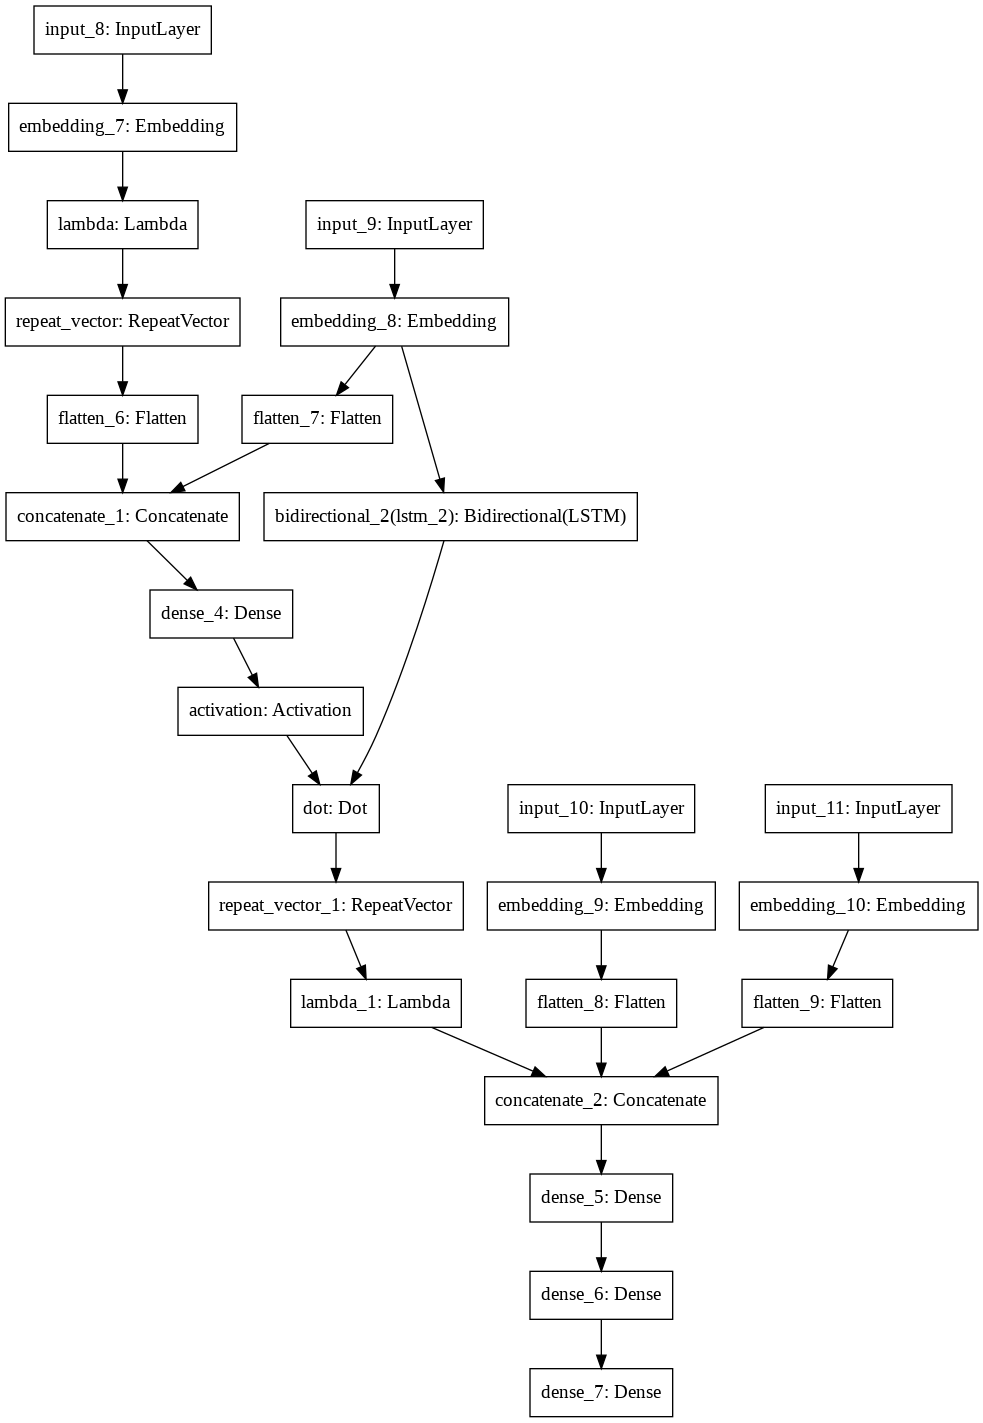

In [0]:
# get the model structure as png
plot_model(model_dec2, to_file='declare_full.png')

In [0]:
4# Model training when lr=0.0001
results = []
for i in range(10):
  history3 = model_dec2.fit([padded_claim,padded_art,padded_claim_src,padded_art_src], label_train,
                    epochs=30,
                    validation_data=([padded_claim_val,padded_art_val,padded_claim_src_val,padded_art_src_val], label_val),
                    batch_size=100)
  y_pred3 = model_dec2.predict([padded_claim_test,padded_art_test,padded_claim_src_test,padded_art_src_test])
  y_pred_bin3 = get_proper_labels(y_pred3)
  result = get_results("deClaRe", "politifact", y_pred_bin3, label_test)
  print(result)
  results.append(result)
process_results(list_to_dict(results))

Train on 23817 samples, validate on 2884 samples
Epoch 1/30
23817/23817 [==============================] - 29s 1ms/sample - loss: 0.0946 - accuracy: 0.9997 - val_loss: 1.1637 - val_accuracy: 0.6113
Epoch 2/30
23817/23817 [==============================] - 29s 1ms/sample - loss: 0.0946 - accuracy: 0.9998 - val_loss: 1.1652 - val_accuracy: 0.6113
Epoch 3/30
23817/23817 [==============================] - 29s 1ms/sample - loss: 0.0946 - accuracy: 0.9997 - val_loss: 1.1691 - val_accuracy: 0.6113
Epoch 4/30
23817/23817 [==============================] - 29s 1ms/sample - loss: 0.0945 - accuracy: 0.9998 - val_loss: 1.1665 - val_accuracy: 0.6127
Epoch 5/30
23817/23817 [==============================] - 29s 1ms/sample - loss: 0.0946 - accuracy: 0.9998 - val_loss: 1.1676 - val_accuracy: 0.6123
Epoch 6/30
23817/23817 [==============================] - 29s 1ms/sample - loss: 0.0945 - accuracy: 0.9998 - val_loss: 1.1640 - val_accuracy: 0.6134
Epoch 7/30
23817/23817 [==============================] -

('deClaRe', 'politifact', precision    0.602775
 recall       0.602473
 accuracy     0.605044
 f1           0.602552
 f1_micro     0.605044
 auc          0.602775
 dtype: float64, precision    0.001732
 recall       0.001747
 accuracy     0.001818
 f1           0.001744
 f1_micro     0.001818
 auc          0.001732
 dtype: float64)

In [0]:
# Model training when lr=0.002
history4_02 = model_dec2.fit([padded_claim,padded_art,padded_claim_src,padded_art_src], label_train,
                    epochs=30,
                    validation_data=([padded_claim_val,padded_art_val,padded_claim_src_val,padded_art_src_val], label_val),
                    batch_size=100)

Train on 18915 samples, validate on 4729 samples
Epoch 1/30
18915/18915 [==============================] - 64s 3ms/step - loss: 1.0581 - acc: 0.5799 - val_loss: 0.7042 - val_acc: 0.6137
Epoch 2/30
18915/18915 [==============================] - 59s 3ms/step - loss: 0.6933 - acc: 0.5940 - val_loss: 0.6854 - val_acc: 0.6060
Epoch 3/30
18915/18915 [==============================] - 59s 3ms/step - loss: 0.6850 - acc: 0.5904 - val_loss: 0.6814 - val_acc: 0.6012
Epoch 4/30
18915/18915 [==============================] - 59s 3ms/step - loss: 0.6835 - acc: 0.5909 - val_loss: 0.6795 - val_acc: 0.6088
Epoch 5/30
18915/18915 [==============================] - 59s 3ms/step - loss: 0.6831 - acc: 0.5906 - val_loss: 0.6792 - val_acc: 0.6046
Epoch 6/30
18915/18915 [==============================] - 59s 3ms/step - loss: 0.6827 - acc: 0.5915 - val_loss: 0.6792 - val_acc: 0.6035
Epoch 7/30
18915/18915 [==============================] - 59s 3ms/step - loss: 0.6824 - acc: 0.5921 - val_loss: 0.6790 - val_acc:

Validation Accuracy: 0.6782
5912/5912 [==============================] - 8s 1ms/step
Testing Accuracy:  0.6768


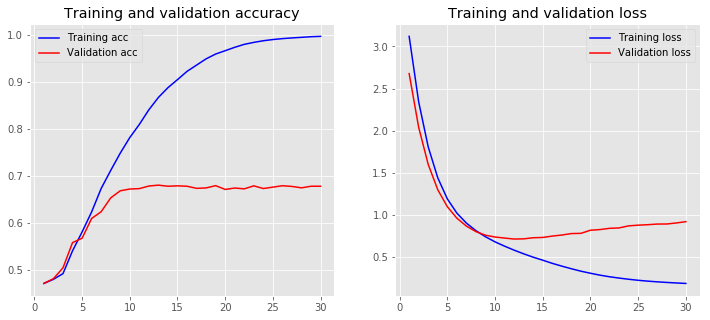

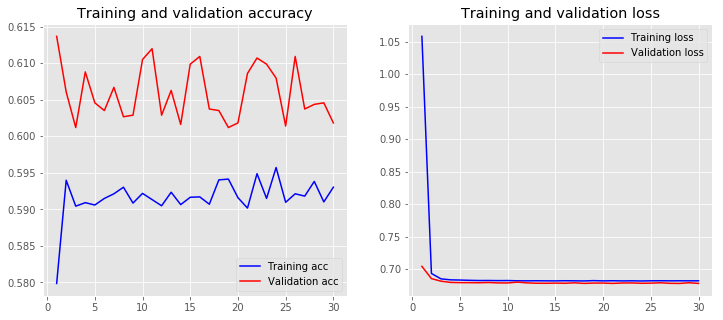

In [0]:
# GEt the loss and accuracy graphs for both learning rates
loss, accuracy = model_dec2.evaluate([padded_claim_val,padded_art_val,padded_claim_src_val,padded_art_src_val], label_val, verbose=False)
print("Validation Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_dec2.evaluate([padded_claim_test,padded_art_test,padded_claim_src_test,padded_art_src_test],label_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history4)
plot_history(history4_02)

In [0]:
# Predict for test data and convert toeithe r0 or 1
y_pred4 = model_dec2.predict([padded_claim_test,padded_art_test,padded_claim_src_test,padded_art_src_test])
y_pred_bin4 = get_proper_labels(y_pred4)

Confusion matrix, without normalization
[[1995  923]
 [ 988 2006]]
Normalized confusion matrix
[[0.68368746 0.31631254]
 [0.32999332 0.67000668]]


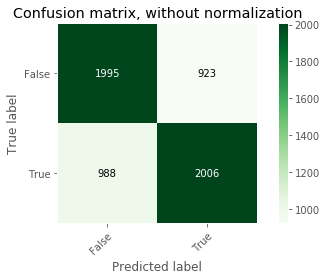

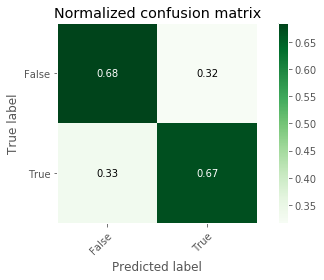

In [0]:
#When lr=0.0001
plot_confusion_matrix(label_test,y_pred_bin4,[0,1])
plot_confusion_matrix(label_test,y_pred_bin4,[0,1], normalize=True)

Confusion matrix, without normalization
[[1931  987]
 [1383 1611]]
Normalized confusion matrix
[[0.66175463 0.33824537]
 [0.46192385 0.53807615]]


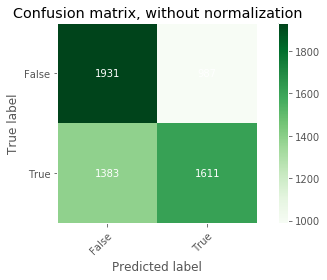

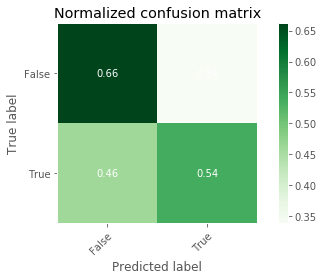

In [0]:
#When lr=0.002
plot_confusion_matrix(label_test,y_pred_bin4,[0,1])
plot_confusion_matrix(label_test,y_pred_bin4,[0,1], normalize=True)

In [0]:
#When lr=0.0001
decalre_p,declare_r,declare_a,declare_f1 = evaluation_summary("DeClarE-Full", y_pred_bin4, label_test)

Evaluation for: DeClarE-Full
Classifier 'DeClarE-Full' has Acc=0.6768 P=0.6768 R=0.6768 F1=0.6768
              precision    recall  f1-score   support

           0      0.684     0.669     0.676      2983
           1      0.670     0.685     0.677      2929

    accuracy                          0.677      5912
   macro avg      0.677     0.677     0.677      5912
weighted avg      0.677     0.677     0.677      5912


Confusion matrix:
 [[1995  923]
 [ 988 2006]]


In [0]:
#When lr=0.0001
fpr, tpr, thresholds = roc_curve(label_test, y_pred_bin4)
auc_declare = auc(fpr, tpr)
print("DeClarE Full AUC-",auc_declare)

DeClarE Full AUC- 0.6768470685945801


In [0]:
#When lr=0.002
decalre_p,declare_r,declare_a,declare_f1 = evaluation_summary("DeClarE-Full", y_pred_bin4, label_test)

Evaluation for: DeClarE-Full
Classifier 'DeClarE-Full' has Acc=0.5991 P=0.5999 R=0.6014 F1=0.5979
              precision    recall  f1-score   support

           0      0.662     0.583     0.620      3314
           1      0.538     0.620     0.576      2598

    accuracy                          0.599      5912
   macro avg      0.600     0.601     0.598      5912
weighted avg      0.607     0.599     0.601      5912


Confusion matrix:
 [[1931  987]
 [1383 1611]]


In [0]:
#When lr=0.002
fpr, tpr, thresholds = roc_curve(label_test, y_pred_bin4)
auc_declare = auc(fpr, tpr)
print("DeClarE Full AUC-",auc_declare)

DeClarE Full AUC- 0.5999153893805432


In [0]:
# Visulaisation
#Creates and HTML file which show the attention weights visulaization on the article. This code taken from: https://github.com/kaushalshetty/Structured-Self-Attention/blob/master
def createHTML(texts, weights, fileName):
    """
    Creates a html file with text heat.
	weights: attention weights for visualizing
	texts: text on which attention weights are to be visualized
    """
    fileName = "visualization/"+fileName
    fOut = open(fileName, "w", encoding="utf-8")
    part1 = """
    <html lang="en">
    <head>
    <meta http-equiv="content-type" content="text/html; charset=utf-8">
    <style>
    body {
    font-family: Sans-Serif;
    }
    </style>
    </head>
    <body>
    <h3>
    Heatmaps
    </h3>
    </body>
    <script>
    """
    part2 = """
    var color = "255,0,0";
    var ngram_length = 3;
    var half_ngram = 1;
    for (var k=0; k < any_text.length; k++) {
    var tokens = any_text[k].split(" ");
    var intensity = new Array(tokens.length);
    var max_intensity = Number.MIN_SAFE_INTEGER;
    var min_intensity = Number.MAX_SAFE_INTEGER;
    for (var i = 0; i < intensity.length; i++) {
    intensity[i] = 0.0;
    for (var j = -half_ngram; j < ngram_length-half_ngram; j++) {
    if (i+j < intensity.length && i+j > -1) {
    intensity[i] += trigram_weights[k][i + j];
    }
    }
    if (i == 0 || i == intensity.length-1) {
    intensity[i] /= 2.0;
    } else {
    intensity[i] /= 3.0;
    }
    if (intensity[i] > max_intensity) {
    max_intensity = intensity[i];
    }
    if (intensity[i] < min_intensity) {
    min_intensity = intensity[i];
    }
    }
    var denominator = max_intensity - min_intensity;
    for (var i = 0; i < intensity.length; i++) {
    intensity[i] = (intensity[i] - min_intensity) / denominator;
    }
    if (k%2 == 0) {
    var heat_text = "<p><br><b>Example:</b><br>";
    } else {
    var heat_text = "<b>Example:</b><br>";
    }
    var space = "";
    for (var i = 0; i < tokens.length; i++) {
    heat_text += "<span style='background-color:rgba(" + color + "," + intensity[i] + ")'>" + space + tokens[i] + "</span>";
    if (space == "") {
    space = " ";
    }
    }
    //heat_text += "<p>";
    document.body.innerHTML += heat_text;
    }
    </script>
    </html>"""
    putQuote = lambda x: "\"%s\""%x
    textsString = "var any_text = [%s];\n"%(",".join(map(putQuote, texts)))
    weightsString = "var trigram_weights = [%s];\n"%(",".join(map(str,weights)))
    fOut.write(part1)
    fOut.write(textsString)
    fOut.write(weightsString)
    fOut.write(part2)
    fOut.close()
  
    return

In [0]:
# Create a new directory called visualization 
!mkdir visualization

In [0]:
#Method to process the article and the attention weights then create the HTML file.
def visualize_attention(wts,x_test_pad,word_to_id,filename):
    wts_add = wts
    wts_add_list = wts_add.tolist()
    id_to_word = {v:k for k,v in word_to_id.items()}
    text= []
    for test in x_test_pad:
        line=list()
        for i in test:
          if i == 0.0:
            word = '<UNK>'
          else:
            word = id_to_word.get(i)
          line.append(word)
        text.append(" ".join(line))
    
    createHTML(text, wts_add_list, filename)
    print("Attention visualization created for {} samples".format(len(x_test_pad)))
    return

In [0]:
# Get the activations of all layers of the model
test_last_idx = 15
activations = get_activations(model_dec2, [padded_claim_test[:test_last_idx,:],padded_art_test[:test_last_idx,:],
                                           padded_claim_src_test[:test_last_idx,:],padded_art_src_test[:test_last_idx,:]])

In [0]:
# Display the layer structures
from keract import display_activations
display_activations(activations, cmap="gray", save=False)

input_18:0 (15, 100) -> Skipped. First dimension is not 1.
input_19:0 (15, 100) -> Skipped. First dimension is not 1.
input_20:0 (15, 4) -> Skipped. First dimension is not 1.
input_21:0 (15, 4) -> Skipped. First dimension is not 1.
embedding_18/embedding_lookup/Identity:0 (15, 100, 100) -> Skipped. First dimension is not 1.
lambda_7/Mean:0 (15, 100) -> Skipped. First dimension is not 1.
repeat_vector_7/Tile:0 (15, 100, 100) -> Skipped. First dimension is not 1.
embedding_19/embedding_lookup/Identity:0 (15, 100, 100) -> Skipped. First dimension is not 1.
flatten_18/Reshape:0 (15, 10000) -> Skipped. First dimension is not 1.
flatten_19/Reshape:0 (15, 10000) -> Skipped. First dimension is not 1.
concatenate_6/concat:0 (15, 20000) -> Skipped. First dimension is not 1.
dense_19/Tanh:0 (15, 100) -> Skipped. First dimension is not 1.
activation_4/Softmax:0 (15, 100) -> Skipped. First dimension is not 1.
bidirectional_7/concat:0 (15, 100, 100) -> Skipped. First dimension is not 1.
dot_4/Squeez

In [0]:
# get weights of the activation layer
wts = activations.get('activation_4/Softmax:0')
wts.shape

(15, 100)

In [0]:
# Create the weight visualization HTML file
word_to_id = t.word_index
visualize_attention(wts,padded_claim_test[:test_last_idx,:],word_to_id,filename='declare_pol_cl.html')

Attention visualization created for 15 samples


## Testing for Unique Claims

Due to the problem of experimental bias introduced into the model, we test the performance of the Hybrid model on unique claims. This bias is introduced because a claim can be associated with many articles and hence can be repeated in traning and test data making it seen data for the model when testing.

In [0]:
# For the Full DeClarE model, when lr = 0.0001
input_test['model_pred2'] = y_pred_bin4
input_test.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,cred_label,claim_id,claim_text,claim_source,article,article_source,pred_bin,model_pred,model_pred2
21584,Half-True,2013_feb_12_barack-obama_barack-obama-touts-ad...,says administration made progress border enfor...,barack obama,obama said the overhaul measure should cut wai...,bna.com,1,1,1
13380,Mostly True,2008_jul_18_barack-obama_senator-did-you-check...,weve heard talk curbing use fossil fuels nearl...,barack obama,oil in our time in this generation this is a d...,calcars.org,1,1,1
15592,True,512.json,john mccain decided stand george bush 95 perce...,barack obama,september previewing the battle ahead obama la...,cnn.com,1,1,1
10646,False,2013_mar_21_harry-reid_harry-reid-says-deficit...,last two years reduced deficit 25 trillion,harry reid,reality check 25 trillion in deficit cuts how ...,cnn.com,0,0,1
17377,True,2012_oct_05_barack-obama_obama-says-romney-wou...,says mitt romney wants add 2 trillion defense ...,barack obama,how much should we spend on defense has propos...,latimes.com,1,1,1


In [0]:
# When lr=0.0001
unique_test_or2 = input_test[~input_test['claim_text'].isin(input_train_in['claim_text'])]
unique_test_or2.head()

,cred_label,claim_id,claim_text,claim_source,article,article_source,pred_bin,model_pred,model_pred2
11976,Pants on Fire!,2017_apr_11_sean-spicer_did-adolf-hitler-use-c...,says adolf hitler didnt even using chemical we...,sean spicer,even hitler didnt sink to using chemical weapo...,independent.co.uk,0,0,0
2760,Half-True,2010_dec_03_michael-steele_rnc-chair-michael-s...,elections chairman since 1938,michael steele,strengthening constitutional publications the ...,ashbrook.org,1,0,0
24400,False,2011_jun_28_jim-demint_jim-demint-says-federal...,weve got revenue ever,jim demint,12th out of 13 conference usa athletic departm...,hattiesburgamerican.com,0,1,1
8775,False,2010_nov_11_rand-paul_rand-paul-says-federal-w...,average federal employee makes year average pr...,rand paul,represent federal workers say on average they ...,factcheck.org,0,1,1
15203,False,2011_jan_07_steny-hoyer_steny-hoyer-says-gop-d...,preparing rules package 112th congress gop no ...,steny hoyer,online ahead of a slated jan 4 organizational ...,washingtonpost.com,0,0,0


Confusion matrix, without normalization
[[56 38]
 [35 30]]
Normalized confusion matrix
[[0.59574468 0.40425532]
 [0.53846154 0.46153846]]


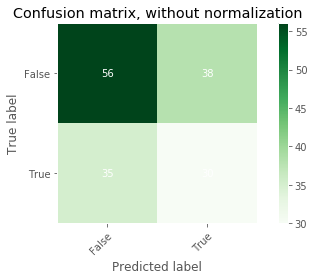

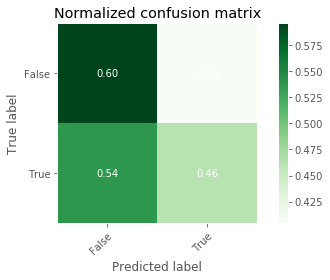

In [0]:
# When lr = 0.0001
bin_pred2=unique_test_or2['pred_bin'].tolist()
pred_val2=unique_test_or2['model_pred2'].tolist()
plot_confusion_matrix(bin_pred2,pred_val2,[0,1])
plot_confusion_matrix(bin_pred2,pred_val2,[0,1], normalize=True)

In [0]:
# When lr =0.0001
uq_p,uq_r,uq_a,uq_f1 = evaluation_summary("Self Attention-Full", pred_val2, bin_pred2)

Evaluation for: Self Attention-Full
Classifier 'Self Attention-Full' has Acc=0.5409 P=0.5286 R=0.5283 F1=0.5283
              precision    recall  f1-score   support

           0      0.596     0.615     0.605        91
           1      0.462     0.441     0.451        68

    accuracy                          0.541       159
   macro avg      0.529     0.528     0.528       159
weighted avg      0.538     0.541     0.539       159


Confusion matrix:
 [[56 38]
 [35 30]]


In [0]:
# When lr=0.0001
fpr, tpr, thresholds = roc_curve(bin_pred2, pred_val2)
auc_basic = auc(fpr, tpr)
print("Self Attention-Full AUC-",auc_basic)

Self Attention-Full AUC- 0.5286415711947627


In [0]:
# DeClarE Full model when lr = 0.002
input_test['model_pred'] = y_pred_bin4
input_test.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,cred_label,claim_id,claim_text,claim_source,article,article_source,pred_bin,model_pred
21584,Half-True,2013_feb_12_barack-obama_barack-obama-touts-ad...,says administration made progress border enfor...,barack obama,obama said the overhaul measure should cut wai...,bna.com,1,1
13380,Mostly True,2008_jul_18_barack-obama_senator-did-you-check...,weve heard talk curbing use fossil fuels nearl...,barack obama,oil in our time in this generation this is a d...,calcars.org,1,1
15592,True,512.json,john mccain decided stand george bush 95 perce...,barack obama,september previewing the battle ahead obama la...,cnn.com,1,1
10646,False,2013_mar_21_harry-reid_harry-reid-says-deficit...,last two years reduced deficit 25 trillion,harry reid,reality check 25 trillion in deficit cuts how ...,cnn.com,0,0
17377,True,2012_oct_05_barack-obama_obama-says-romney-wou...,says mitt romney wants add 2 trillion defense ...,barack obama,how much should we spend on defense has propos...,latimes.com,1,1


In [0]:
# When lr=0.002
unique_test_or = input_test[~input_test['claim_text'].isin(input_train_in['claim_text'])]
unique_test_or.head()

,cred_label,claim_id,claim_text,claim_source,article,article_source,pred_bin,model_pred
11976,Pants on Fire!,2017_apr_11_sean-spicer_did-adolf-hitler-use-c...,says adolf hitler didnt even using chemical we...,sean spicer,even hitler didnt sink to using chemical weapo...,independent.co.uk,0,0
2760,Half-True,2010_dec_03_michael-steele_rnc-chair-michael-s...,elections chairman since 1938,michael steele,strengthening constitutional publications the ...,ashbrook.org,1,0
24400,False,2011_jun_28_jim-demint_jim-demint-says-federal...,weve got revenue ever,jim demint,12th out of 13 conference usa athletic departm...,hattiesburgamerican.com,0,1
8775,False,2010_nov_11_rand-paul_rand-paul-says-federal-w...,average federal employee makes year average pr...,rand paul,represent federal workers say on average they ...,factcheck.org,0,1
15203,False,2011_jan_07_steny-hoyer_steny-hoyer-says-gop-d...,preparing rules package 112th congress gop no ...,steny hoyer,online ahead of a slated jan 4 organizational ...,washingtonpost.com,0,0


Confusion matrix, without normalization
[[59 35]
 [29 36]]
Normalized confusion matrix
[[0.62765957 0.37234043]
 [0.44615385 0.55384615]]


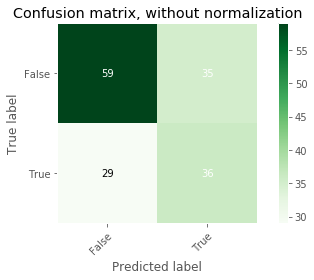

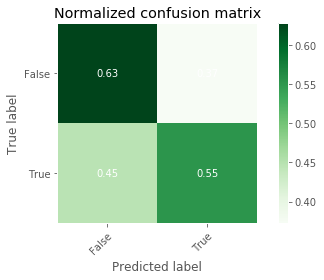

In [0]:
# When lr=0.002
bin_pred=unique_test_or['pred_bin'].tolist()
pred_val=unique_test_or['model_pred'].tolist()
plot_confusion_matrix(bin_pred,pred_val,[0,1])
plot_confusion_matrix(bin_pred,pred_val,[0,1], normalize=True)

In [0]:
# When lr=0.002
uq_p,uq_r,uq_a,uq_f1 = evaluation_summary("Self Attention-Full", pred_val, bin_pred)

Evaluation for: Self Attention-Full
Classifier 'Self Attention-Full' has Acc=0.5975 P=0.5908 R=0.5887 F1=0.5889
              precision    recall  f1-score   support

           0      0.628     0.670     0.648        88
           1      0.554     0.507     0.529        71

    accuracy                          0.597       159
   macro avg      0.591     0.589     0.589       159
weighted avg      0.595     0.597     0.595       159


Confusion matrix:
 [[59 35]
 [29 36]]


In [0]:
# When lr=0.002
fpr, tpr, thresholds = roc_curve(bin_pred, pred_val)
auc_basic = auc(fpr, tpr)
print("Self Attention-Full AUC-",auc_basic)

Self Attention-Full AUC- 0.5907528641571195


In [0]:
# Get the statistics of the unique claims
label_counts = unique_test_or['pred_bin'].value_counts()
print(label_counts.describe())
top_labels = label_counts.nlargest(5)
top_labels_list = top_labels.index.tolist()
print(top_labels)

count     2.000000
mean     79.500000
std      20.506097
min      65.000000
25%      72.250000
50%      79.500000
75%      86.750000
max      94.000000
Name: pred_bin, dtype: float64
0    94
1    65
Name: pred_bin, dtype: int64


In [0]:
incorrect = unique_test_or[unique_test_or['pred_bin']!=unique_test_or['model_pred'].astype(int)]
incorrect

,cred_label,claim_id,claim_text,claim_source,article,article_source,pred_bin,model_pred
2760,Half-True,2010_dec_03_michael-steele_rnc-chair-michael-s...,elections chairman since 1938,michael steele,strengthening constitutional publications the ...,ashbrook.org,1,0
24400,False,2011_jun_28_jim-demint_jim-demint-says-federal...,weve got revenue ever,jim demint,12th out of 13 conference usa athletic departm...,hattiesburgamerican.com,0,1
8775,False,2010_nov_11_rand-paul_rand-paul-says-federal-w...,average federal employee makes year average pr...,rand paul,represent federal workers say on average they ...,factcheck.org,0,1
24968,Mostly True,2011_feb_22_donna-brazile_donna-brazile-said-w...,wisconsin governor proposed tax giveaways corp...,donna brazile,value of future dollars meaning the real dolla...,isthmus.com,1,0
4483,Mostly False,2011_jun_24_tim-pawlenty_pawlenty-says-obama-g...,says president barack obama promised would cut...,tim pawlenty,long after that that i lost interest i would r...,wordpress.com,0,1
20475,Half-True,2009_jul_30_bill-pascrell_pascrell-says-53-per...,53 percent americans cut back health care last...,bill pascrell,before their natural deaths as the dutch data ...,nejm.org,1,0
627,Mostly True,2007_aug_23_john-edwards_correct-but-he-uses-t...,estimated 56 million americans dont bank accounts,john edwards,missing assets unclaimed pension and retiremen...,missingassets.com,1,0
2786,Pants on Fire!,2010_dec_16_tim-pawlenty_tim-pawlenty-repeats-...,since january 2008 private sector lost nearly ...,tim pawlenty,up to 24 days of unpaid furlough days while ou...,chicagotribune.com,0,1
8995,Mostly False,2012_sep_14_mitt-romney_romney-claims-5-studie...,says five studies show tax plan cut rates stil...,mitt romney,0 points 5 years ago 3 children this is semant...,reddit.com,0,1
17132,Half-True,2017_nov_30_kevin-brady_does-70-percent-tax-bi...,house republican bill 70 percent tax relief go...,kevin brady,50 percent in 2027 and if you factor in the im...,mystatesman.com,1,0


In [0]:
# Write to csv
unique_test_or.to_csv('declare_politifact.csv', sep='\t')

## Bibliography

Kashyap Popat, Subhabrata Mukherjee, Andrew Yates and Gerhard Weikum, <i>DeClarE: Debunking Fake News and False Claims using Evidence-Aware Deep Learning</i>, Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing, Pages 22-32, 2018.